In [2]:
import numpy as np
import pandas as pd
import os

def ReadSingleDataframe(PATH: str, meta_file: str, binState_file: str, num_slots: int = 240, num_links: int = 3) -> pd.DataFrame:

    # Checa se os arquivos meta e binState estão referenciando o mesmos dados
    if meta_file[9:] != binState_file[13:]:
        raise ValueError("Os arquivos de metadados e estado dos slots não estão referenciando os mesmos dados.")

    print(f"Nome do arquivo de metadados: {meta_file}, Nome do arquivo de estado dos slots: {binState_file}. ")

    # Caminho completo para o arquivo de metadados
    completePath = PATH + meta_file
    
    # * Excuta o MSCL para a rota principal e suas rotas interferentes e coleta os dados para armazenar. Os dados coletados são:
    # * 1. O melhor slot para alocar a requisição segundo o MSCL (bestIndexSlot) : int
    # * 2. A melhor perda de capacidade para alocar a requisição segundo o MSCL (bestCapacityLoss) : int
    # * 3. A tag que indica qual foi o melhor slot encontrado. 0 - First Fit. 1 - MSCL. 2 - Last Fit (tag) : int
    # * 4. O ID da requisição (reqID) : int
    # * 5. O tamanho da requisição a ser alocada (reqNumbOfSlots) : int
    # * 6. O ID da rota principal (routeID) : int
    # * 7. O valor da capacidade antes da alocação, na rota principal (cpBefore) : int
    # * 8. O valor da capacidade antes da alocação, na rota interferente 1 (cpBefore_i1) : int
    # * 9. O valor da capacidade antes da alocação, na rota interferente 2 (cpBefore_i2) : int
    # * 10. O valor da capacidade depois da alocação em FF, na rota principal (cp_FF_After_r1) : int
    # * 11. O valor da capacidade depois da alocação em FF, na rota interferente 1 (cp_FF_After_r2) : int
    # * 12. O valor da capacidade depois da alocação em FF, na rota interferente 2 (cp_FF_After_r3) : int
    # * 13. O valor da capacidade depois da alocação em LF, na rota principal (cp_LF_After_r1) : int
    # * 14. O valor da capacidade depois da alocação em LF, na rota interferente 1 (cp_LF_After_r2) : int
    # * 15. O valor da capacidade depois da alocação em LF, na rota interferente 2 (cp_LF_After_r3) : int
    # * 16. Ocupação da rota principal antes da alocação (ocupationBefore_r1) : int
    # * 17. Ocupação da rota interferente 1 antes da alocação (ocupationBefore_r2) : int
    # * 18. Ocupação da rota interferente 2 antes da alocação (ocupationBefore_r3) : int
    # * 19. Slot inicial da alocação em FF (slotFF) : int
    # * 20. Slot inicial da alocação em LF (slotLF) : int
        
    # Lista com os nomes das colunas do dataframe
    fNames = ['IndexDF', 'bestIndexSlot', 'bestCapacityLoss','tag', 'reqID', 'reqNumbOfSlots', 'routeID', 'cpBefore_r1', 'cpBefore_r2', 'cpBefore_r3', 'cp_FF_After_r1', 'cp_FF_After_r2', 'cp_FF_After_r3', 'cp_LF_After_r1', 'cp_LF_After_r2', 'cp_LF_After_r3', 'ocupationBefore_r1', 'ocupationBefore_r2', 'ocupationBefore_r3', 'slotFF', 'slotLF']

    # Lista com os tipos de dados das colunas do dataframe
    fdType = ['>i4, ' for i in range(len(fNames) - 1)]
    fdType.append('>i4')

    # Concatenando os tipos de dados em uma única string
    fdType = ''.join(fdType)

    # Criando o tipo de dado para o dataframe
    dt = np.dtype(fdType)

    # Ler o arquivo usando o tipo de dado criado
    data = np.fromfile(completePath, dtype=dt)

    # Converter a lista de tuplas em uma matriz do numpy
    data = np.array(data, dtype=dt)

    # Converter o tipo de dado para little-endian
    data = data.byteswap().newbyteorder()

    # Criar os dicionários com os tipos de dados para cada coluna
    data_types = {}
    for name in fNames:
        data_types[name] = np.uint32

    # Criar o dataframe com os dados de metadados
    df_metadata = pd.DataFrame(data=data)

    # Renomear as colunas do dataframe
    df_metadata.columns = fNames

    # Converter as colunas para os tipos de dados corretos
    df_metadata = df_metadata.astype(data_types)

    del fNames, fdType, dt, data, completePath, data_types

    ### Lendo o estado dos slots

    # Caminho completo para o arquivo de estado dos slots
    completePath = PATH + binState_file

    # Ler os bytes compactados do arquivo
    with open(completePath, "rb") as file:
        compactedData = file.read()
    
    # Converter os bytes compactados para um array numpy de int8
    compactedArray = np.frombuffer(compactedData, dtype=np.uint8)

    # Converter os valores inteiros para binário
    binaryData = np.unpackbits(compactedArray)

    # Redimensionar o array para o formato adequado (número de slots e links)
    binaryData = binaryData.reshape(-1, num_slots * num_links)

    # Cria o nome das colunas do dataframe
    sCName = [f's_{i}' for i in range(num_slots * num_links)]

    # Cria o dataframe com os dados binários
    df_slots = pd.DataFrame(data=binaryData, columns=sCName)

    # Cria o tipo de dados para as colunas do dataframe
    data_types = {col: np.bool_ for col in df_slots.columns}

    # Converte as colunas para os tipos de dados corretos
    df_slots = df_slots.astype(data_types)

    del completePath, file, compactedData, compactedArray, binaryData, sCName, data_types

    ### Mesclando os dados em um único dataframe

    # Usando o método merge para combinar os dataframes df_metadata e df_slots
    df_combined = pd.merge(df_metadata, df_slots, left_on="IndexDF", right_index=True)

    # Eliminando do dataframe as colunas que são serão usadas
    df_combined = df_combined.drop(columns=['IndexDF'])

    del df_slots, df_metadata

    return df_combined

C:\Users\mathe\AppData\Local\Temp\ipykernel_30328\3975192723.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Encontrando a path da pasta anterior a pasta atual, junto com 'src-java\data\'
PATH = os.path.dirname(os.getcwd()) + '\\src-java\\data\\'

# ! Informações importantes. A parta onde estão os arquivos e a quantidade de slots e links devem ser alterados aqui.
PATH += "iTwo_database\\"
NUM_SLOTS = 240
NUM_VECTORS = 3

meta_filenames = [arq for arq in os.listdir(PATH) if arq.startswith("metaData") and arq.endswith(".bin")]
binState_filenames = [arq for arq in os.listdir(PATH) if arq.startswith('binStateData') and arq.endswith(".bin")]

for meta, binState in zip(meta_filenames, binState_filenames):
    print(f"Meta: {meta}, binState: {binState}")

# Ler todos os dataframes e armazena em uma lista
all_dataframes = []

# Percorrendo o número de simulações
for index in range(len(meta_filenames)):
    print(f"Simulação {index + 1} de {len(meta_filenames)}. ", end='')

    # Lendo o dataframe da simulação atual
    df1 = ReadSingleDataframe(PATH, meta_filenames[index], binState_filenames[index], NUM_SLOTS, NUM_VECTORS)

    # Salvando o dataframe atual na lista de dataframes
    all_dataframes.append(df1)

df_main = pd.concat(all_dataframes, axis=0).reset_index(drop=True)

Meta: metaData_1_80.0.bin, binState: binStateData_1_80.0.bin
Meta: metaData_2_80.0.bin, binState: binStateData_2_80.0.bin
Meta: metaData_3_80.0.bin, binState: binStateData_3_80.0.bin
Meta: metaData_4_80.0.bin, binState: binStateData_4_80.0.bin
Meta: metaData_5_80.0.bin, binState: binStateData_5_80.0.bin
Meta: metaData_6_80.0.bin, binState: binStateData_6_80.0.bin
Simulação 1 de 6. Nome do arquivo de metadados: metaData_1_80.0.bin, Nome do arquivo de estado dos slots: binStateData_1_80.0.bin. 
Simulação 2 de 6. Nome do arquivo de metadados: metaData_2_80.0.bin, Nome do arquivo de estado dos slots: binStateData_2_80.0.bin. 
Simulação 3 de 6. Nome do arquivo de metadados: metaData_3_80.0.bin, Nome do arquivo de estado dos slots: binStateData_3_80.0.bin. 
Simulação 4 de 6. Nome do arquivo de metadados: metaData_4_80.0.bin, Nome do arquivo de estado dos slots: binStateData_4_80.0.bin. 
Simulação 5 de 6. Nome do arquivo de metadados: metaData_5_80.0.bin, Nome do arquivo de estado dos slots: 

In [4]:
# Trocando os valores da coluna 'routeID'. 0 -> 1, 1 -> 2, 2 -> 3 e 4 -> 4
df_main['routeID'] = df_main['routeID'].replace({0: 0, 1: 1, 2: 2, 4: 3})

In [5]:
print(f"df_main.shape: {df_main.shape}")

df_main.head()

df_main.shape: (7172671, 740)


,bestIndexSlot,bestCapacityLoss,tag,reqID,reqNumbOfSlots,routeID,cpBefore_r1,cpBefore_r2,cpBefore_r3,cp_FF_After_r1,...,s_710,s_711,s_712,s_713,s_714,s_715,s_716,s_717,s_718,s_719
0,208,3,1,10004,2,0,243,221,142,237,...,True,True,True,True,True,True,True,True,True,True
1,207,3,1,10004,3,0,243,221,142,234,...,True,True,True,True,True,True,True,True,True,True
2,9,17,0,10004,6,0,243,221,142,226,...,True,True,True,True,True,True,True,True,True,True
3,221,5,2,10004,2,1,221,243,156,215,...,False,False,True,True,True,True,True,True,True,True
4,94,9,1,10004,3,1,221,243,156,212,...,False,False,True,True,True,True,True,True,True,True


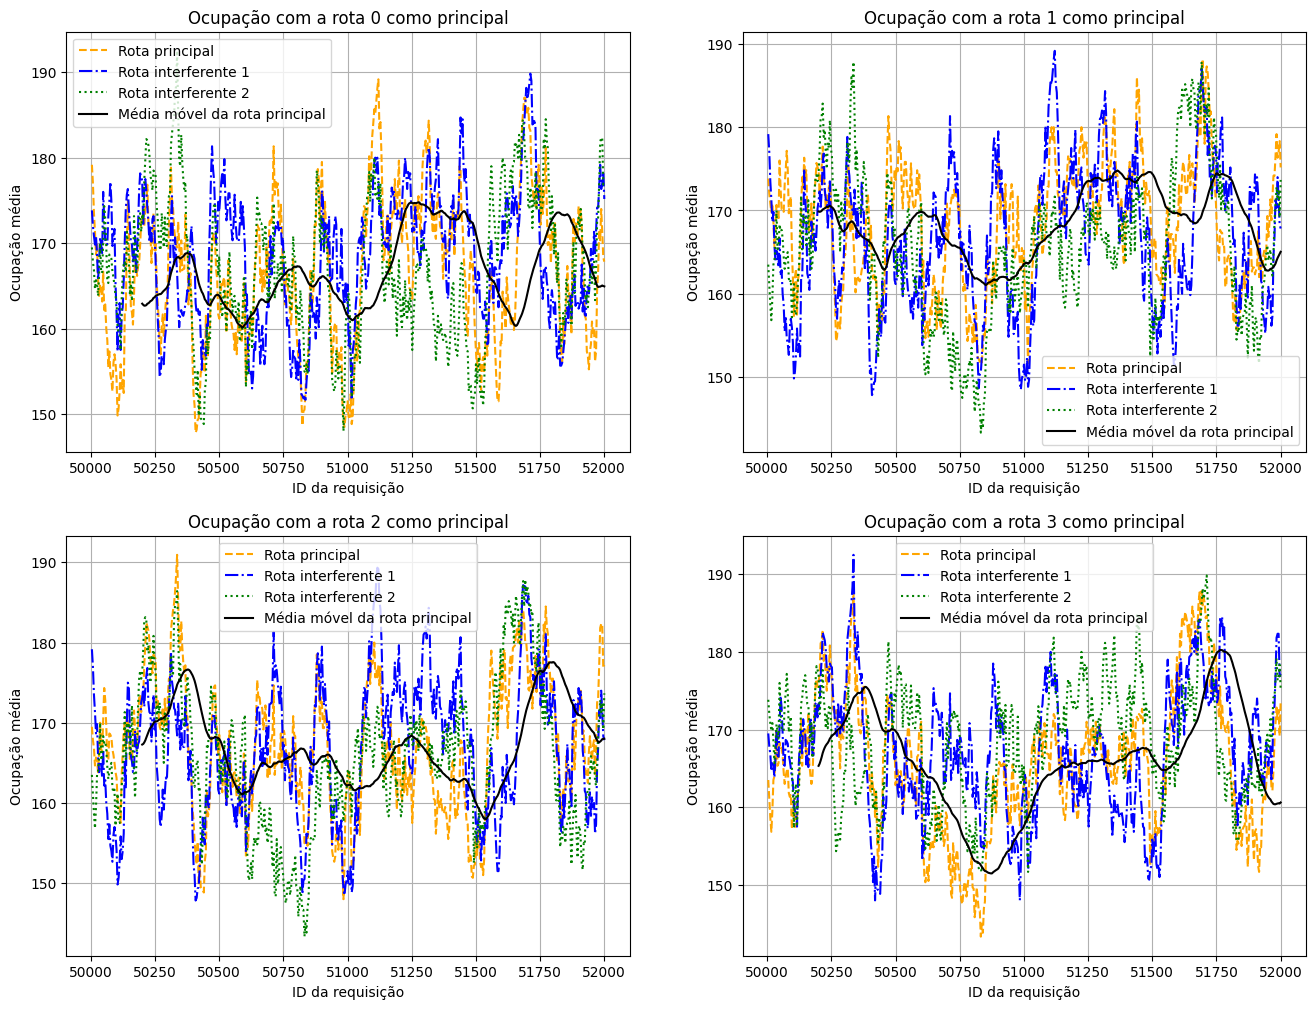

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Cria uma cópia do dataframe principal com as colunas de interesse
df_main_ocupation = df_main[['reqID', 'ocupationBefore_r1', 'ocupationBefore_r2', 'ocupationBefore_r3', 'routeID']].copy()

# Agrupa os dados por 'reqID' e 'routeID' e calcula a média da ocupação
df_main_ocupation = df_main_ocupation.groupby(['reqID', 'routeID']).mean().reset_index()

# Cria uma figura com 4 gráficos, 1 na primeira linha ocupando as 3 colunas e 3 na segunda linha. Cada gráfico de barra representa as colunas 'slotIndex', 'currentSlotReq', 'routeID' e 'tag' respectivamente.
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

def plotOcupationChart(axs, routeID, slice_start):
    df_r = df_main_ocupation[df_main_ocupation['routeID'] == routeID]
    df_r = df_r[slice_start:slice_start+500]
    axs.plot(df_r['reqID'], df_r['ocupationBefore_r1'], label='Rota principal', color='orange', linestyle='--')
    axs.plot(df_r['reqID'], df_r['ocupationBefore_r2'], label='Rota interferente 1', color='blue', linestyle='-.')
    axs.plot(df_r['reqID'], df_r['ocupationBefore_r3'], label='Rota interferente 2', color='green', linestyle=':')

    # Média móvel da ocupação da rota principal. Janela de 100 amostras
    axs.plot(df_r['reqID'], df_r['ocupationBefore_r1'].rolling(50).mean(), label='Média móvel da rota principal', color='k', linestyle='-')

    axs.set_title(f"Ocupação com a rota {routeID} como principal")
    axs.set_xlabel("ID da requisição")
    axs.set_ylabel("Ocupação média")
    axs.legend()
    axs.grid(True)

plotOcupationChart(ax0, 0, 10000)
plotOcupationChart(ax1, 1, 10000)
plotOcupationChart(ax2, 2, 10000)
plotOcupationChart(ax3, 3, 10000)

plt.show()

In [7]:
# Nome das colunas, excepto as colunas de slots
colNames_meta = df_main.columns.tolist()

# Remove as colunas de slots que começam com 's_'
colNames_meta = [col for col in colNames_meta if not col.startswith('s_')]

In [8]:
colNames_meta

['bestIndexSlot',
 'bestCapacityLoss',
 'tag',
 'reqID',
 'reqNumbOfSlots',
 'routeID',
 'cpBefore_r1',
 'cpBefore_r2',
 'cpBefore_r3',
 'cp_FF_After_r1',
 'cp_FF_After_r2',
 'cp_FF_After_r3',
 'cp_LF_After_r1',
 'cp_LF_After_r2',
 'cp_LF_After_r3',
 'ocupationBefore_r1',
 'ocupationBefore_r2',
 'ocupationBefore_r3',
 'slotFF',
 'slotLF']

In [9]:
# Faz o describe do dataframe com os valores de metadados sem estar em notação científica
df_main[colNames_meta].describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,bestIndexSlot,bestCapacityLoss,tag,reqID,reqNumbOfSlots,routeID,cpBefore_r1,cpBefore_r2,cpBefore_r3,cp_FF_After_r1,cp_FF_After_r2,cp_FF_After_r3,cp_LF_After_r1,cp_LF_After_r2,cp_LF_After_r3,ocupationBefore_r1,ocupationBefore_r2,ocupationBefore_r3,slotFF,slotLF
count,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000,7172671.000000
mean,118.838010,10.703766,0.956044,210007.231963,3.658316,1.500014,154.753879,154.768534,154.397486,146.102429,148.321213,147.952910,146.035690,148.159532,147.795144,166.723983,166.724432,166.860247,33.011930,205.654993
std,75.195042,12.236672,0.681941,115468.337545,1.697024,1.118029,62.340909,62.682634,62.469062,62.131585,61.862634,61.645092,62.145740,61.905870,61.703507,22.373396,22.511345,22.434314,32.264707,32.192314
min,0.000000,1.000000,0.000000,10004.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,70.000000,70.000000,0.000000,0.000000
25%,49.000000,3.000000,0.000000,110024.000000,2.000000,1.000000,110.000000,110.000000,110.000000,102.000000,104.000000,104.000000,101.000000,104.000000,104.000000,151.000000,151.000000,151.000000,9.000000,193.000000
50%,121.000000,6.000000,1.000000,210008.000000,3.000000,1.000000,154.000000,154.000000,154.000000,145.000000,147.000000,147.000000,145.000000,147.000000,147.000000,167.000000,167.000000,167.000000,24.000000,216.000000
75%,188.000000,14.000000,1.000000,310012.000000,6.000000,3.000000,198.000000,198.000000,197.000000,189.000000,191.000000,190.000000,189.000000,191.000000,190.000000,182.000000,182.000000,182.000000,47.000000,229.000000
max,238.000000,62.000000,2.000000,410000.000000,6.000000,3.000000,444.000000,444.000000,444.000000,441.000000,439.000000,440.000000,438.000000,444.000000,440.000000,238.000000,239.000000,239.000000,238.000000,238.000000


In [10]:
# Representação dos valores da coluna tag em proporção ao lado do count

print(df_main['tag'].value_counts(normalize=True) * 100)

print(df_main['tag'].value_counts())



tag
1    53.302403
0    25.546606
2    21.150991
Name: proportion, dtype: float64
tag
1    3823206
0    1832374
2    1517091
Name: count, dtype: int64


In [11]:
N_REGIONS = 4

# Defina os limites dos slots
lower_bound = 0
upper_bound = NUM_SLOTS // N_REGIONS

# Defina as condições e os valores correspondentes
conditions = [
    (df_main['tag'] == 0),
    (df_main['tag'] == 2),
    (df_main['bestIndexSlot'].between(lower_bound, upper_bound, inclusive="left")),
    (df_main['bestIndexSlot'].between(upper_bound, upper_bound * 2, inclusive="left")),
    (df_main['bestIndexSlot'].between(upper_bound * 2, upper_bound * 2 + upper_bound, inclusive="left")),
]

values = [0, 1, 2, 3, 4]

# Cria uma nova coluna e usa np.select para atribuir valores a ela usando nossas listas como argumentos
df_main['output'] = np.select(conditions, values, 5)

    

In [12]:
# Aplicando a lengenda
print(f"FF = 0\nLF = 1\nRegion 1 = 2\nRegion 2 = 3\nRegion 3 = 4\nRegion 4 = 5\n")

df_main.output.value_counts()

FF = 0
LF = 1
Region 1 = 2
Region 2 = 3
Region 3 = 4
Region 4 = 5



output
0    1832374
1    1517091
4    1275489
3    1129363
5     797719
2     620635
Name: count, dtype: int64

In [13]:
# Deixando somente 20400000 amostras no dataframe, com 10200000 amostra de cada classe 'slotIndex'
df_main_balanced = df_main.groupby('output').apply(lambda x: x.sample(n=min(620635, len(x)), random_state=42)).reset_index(drop=True)

C:\Users\mathe\AppData\Local\Temp\ipykernel_30328\3183028397.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_main_balanced = df_main.groupby('output').apply(lambda x: x.sample(n=min(620635, len(x)), random_state=42)).reset_index(drop=True)


In [14]:
del df_main

In [15]:
# Salvando o dataframe em um arquivo binário
df_main_balanced.to_pickle('df_main_balanced.pkl')

In [11]:
import pandas as pd
import numpy as np

df_main_balanced = pd.read_pickle('df_main_balanced.pkl')

NUM_SLOTS = 240
N_REGIONS = 4

In [12]:
s_cols = ['s_{}'.format(i) for i in range(NUM_SLOTS)]

if NUM_SLOTS % N_REGIONS != 0:
    raise ValueError('Number of slots must be divisible by number of regions.')

index = 0
MAX = len(df_main_balanced)

# Percorre todas as linhas do data frame
for row in df_main_balanced.iloc:

    if index % 10000 == 0:
        print(f"index: {index} de {MAX}")
    index += 1
    
    demand = row['reqNumbOfSlots']

    # Cria um vetor de disponibilidade de slots para todo o espectro
    availability_vector = row[s_cols].values

    # Percorre todas as regiões
    for region_ID in range(N_REGIONS):
        
        # Verifica se há slots disponíveis na região atual para a demanda atual
        for slot in range((NUM_SLOTS // N_REGIONS) * region_ID, (NUM_SLOTS // N_REGIONS) * (region_ID + 1)):

            if slot + demand > NUM_SLOTS:
                break

            is_available = True
            for j in range(demand):
                if availability_vector[slot + j]:
                    is_available = False
                    break
            if is_available:
                
                # Escreve True na linha atual e coluna atual 'region_{region_ID}'
                df_main_balanced.at[row.name, 'region_{}'.format(region_ID)] = True
                break

        # Se não houver slots disponíveis para a demanda atual, escreve False em todas as colunas 'region_{region_ID}'
        if not is_available:
            df_main_balanced.at[row.name, 'region_{}'.format(region_ID)] = False

index: 0 de 3723810
index: 10000 de 3723810
index: 20000 de 3723810
index: 30000 de 3723810
index: 40000 de 3723810
index: 50000 de 3723810
index: 60000 de 3723810
index: 70000 de 3723810
index: 80000 de 3723810
index: 90000 de 3723810
index: 100000 de 3723810
index: 110000 de 3723810
index: 120000 de 3723810
index: 130000 de 3723810
index: 140000 de 3723810
index: 150000 de 3723810
index: 160000 de 3723810
index: 170000 de 3723810
index: 180000 de 3723810
index: 190000 de 3723810
index: 200000 de 3723810
index: 210000 de 3723810
index: 220000 de 3723810
index: 230000 de 3723810
index: 240000 de 3723810
index: 250000 de 3723810
index: 260000 de 3723810
index: 270000 de 3723810
index: 280000 de 3723810
index: 290000 de 3723810
index: 300000 de 3723810
index: 310000 de 3723810
index: 320000 de 3723810
index: 330000 de 3723810
index: 340000 de 3723810
index: 350000 de 3723810
index: 360000 de 3723810
index: 370000 de 3723810
index: 380000 de 3723810
index: 390000 de 3723810
index: 400000 

In [14]:
# Salvnado com as regiões
df_main_balanced.to_pickle('df_main_balanced_regions.pkl')

In [15]:
df_main_balanced.region_0.value_counts()

region_0
True     3173200
False     550610
Name: count, dtype: int64

In [16]:
df_main_balanced.region_1.value_counts()

region_1
True     3478609
False     245201
Name: count, dtype: int64

In [17]:
df_main_balanced.region_2.value_counts()

region_2
True     3447510
False     276300
Name: count, dtype: int64

In [18]:
df_main_balanced.region_3.value_counts()

region_3
True     3143008
False     580802
Name: count, dtype: int64